## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import qstools.indicators as qsi
import math

import warnings
warnings.simplefilter('ignore')

In [117]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

cids_eufx = ['CHF', 'HUF', 'NOK', 'PLN', 'RON', 'SEK']  # EUR benchmark
cids_g2fx = ['GBP', 'RUB', 'TRY']  # dual benchmark
cids_usfx = ['AUD', 'BRL', 'CAD', 'CLP', 'CNY', 'COP', 'EUR', 'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MYR',
             'MXN', 'NZD', 'PEN', 'PHP', 'SGD', 'THB', 'TWD', 'ZAR']  # USD benchmark
cids_fx = cids_usfx + cids_eufx + cids_g2fx 

In [162]:
from_DB = True
path_to_feather = "..//data//feathers//"  # 
xcats = ['INTRGDP_NSA_P1M1ML12_3MMA',  # GROWTH_DIFF
         'BXBGDPRATIO_NSA_12MMA', 'MTBGDPRATIO_NSA_12MMA_D1M1ML3',  # XBAL_STRENGTH
         'INFTEFF_NSA', 'CPIC_SJA_P6M6ML6AR',  'CPIH_SJA_P6M6ML6AR', # INF_PRESSURE
         'PCREDITGDP_SJA_D1M1ML12', 'PCREDITBN_SJA_P1M1ML12',  # CREDIT_DIFF
         'RIRvBM_NSA', 'FXCRR_NSA',  # REALRATE_DIFF
         'NEER_NSA_P1M1ML12', 'REER_NSA_P1M60ML1',  # FXWEAK
         'FXXRBETAvGDRB_NSA']  # RISK_BETA_NEG

# Add REER

if from_DB:
    
    dbi = qsi.DownloadQuantamentalIndicators(username="rsueppel",
                                             host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                             password="l3oT7^WerjY#O!9EGqvL",
                                             database="qs_jpm_point_time")
    dfd_imp = dbi.get_xcat(cross_section = cids, xcat = xcats).reset_index(drop=True)    
    dfd_imp.to_feather(f'{path_to_feather}dfd_fxmacro.ftr')
        
else:
        
    dfd_imp = pd.read_feather(f'{path_to_feather}dfd_fxmacro.ftr')

In [164]:
dfd_imp[['cid', 'cat']] = dfd_imp['ticker'].str.split('_', 1, expand=True)  # split string column
dfd_imp['real_date'] = pd.to_datetime(dfd_imp['real_date'])
dfd_imp.sort_values(['ticker', 'real_date'], inplace=True)

In [165]:
dfd_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302816 entries, 1658438 to 1507963
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ticker     object        
 1   real_date  datetime64[ns]
 2   value      float64       
 3   grading    object        
 4   eop_lag    int64         
 5   mop_lag    int64         
 6   cid        object        
 7   cat        object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 158.1+ MB


In [274]:
dfd = dfd_imp[['cid', 'cat', 'real_date', 'value']]

In [275]:
cids_exp = cids_fx + ['USD']  # expected cids
xcats_exp = xcats  # expected xcats, in most cases equal to xcats

print('Missing xcats across df: ', set(xcats_exp) - set(dfd['cat'].unique()))  # any xcats missing
xcats_used = sorted(list(set(xcats_exp).intersection(set(dfd['cat'].unique()))))
for xcat in xcats_used:
    cids_xcat = dfd.loc[dfd['cat']==xcat, 'cid'].unique()
    print(f'Missing cids for {xcat}: ', set(cids_exp) - set(cids_xcat))  # any cross section missing?

Missing xcats across df:  set()
Missing cids for BXBGDPRATIO_NSA_12MMA:  set()
Missing cids for CPIC_SJA_P6M6ML6AR:  set()
Missing cids for CPIH_SJA_P6M6ML6AR:  set()
Missing cids for FXCRR_NSA:  {'USD'}
Missing cids for FXXRBETAvGDRB_NSA:  {'USD'}
Missing cids for INFTEFF_NSA:  set()
Missing cids for INTRGDP_NSA_P1M1ML12_3MMA:  set()
Missing cids for MTBGDPRATIO_NSA_12MMA_D1M1ML3:  set()
Missing cids for NEER_NSA_P1M1ML12:  set()
Missing cids for PCREDITBN_SJA_P1M1ML12:  set()
Missing cids for PCREDITGDP_SJA_D1M1ML12:  set()
Missing cids for REER_NSA_P1M60ML1:  set()
Missing cids for RIRvBM_NSA:  {'USD'}


## Functions

In [287]:
def znscore(df, xcats, cids = None, start = '2000-01-01', pw=0, signs=None):
    dfx = df.loc[(df['real_date'] >= pd.to_datetime(start)), ]
    
    if signs is None:
        signs = [1] * len(xcats)
    
    cids_in_df = dfx['cid'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cid'].isin(cids)]

    dfzn = pd.DataFrame(columns = df.columns)
    for xcat, sign in zip(xcats, signs):
        dfxx = dfx[(dfx['cat'] == xcat)].pivot(index='real_date', columns='cid', values='value')
        pan_mabs = dfxx.abs().mean()  # panel mean absolute value
        cid_mabs = dfxx.apply(lambda x: np.mean(abs(x)), axis=0)  # cross-sectional mean absolute values
        dfxa = sign * dfxx / (pw * pan_mabs + (1-pw) * cid_mabs)  # weighted average of panel and cs means
        dfxa = dfxa.unstack().reset_index().rename({0 : 'value'}, axis=1)
        dfxa['cat'] = xcat + 'ZN' if sign == 1 else xcat + 'ZNN'
        dfzn = dfzn.append(dfxa[df.columns])
    return dfzn.reset_index(drop=True)

In [277]:
def group_zn(df, xcats, cids=None, gname='GROUP_ZN', re_zn = True):
    
    dfx = df[df['cat'].isin(xcats)]
    cids_in_df = dfx['cid'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cid'].isin(cids)]

    dfx_piv = dfx.pivot(index=['cid', 'real_date'], columns='cat', values='value')

    dfxx = dfx_piv.mean(axis=1).reset_index().rename({0 : 'value'}, axis=1)
    if re_zn:
        dfxx['value'] = dfxx['value'] / dfxx['value'].abs().mean()
    dfxx['cat'] = gname
    return dfxx[df.columns]

In [307]:
def global_score(df, xcats, cids=None, score_date=None, rank=True, header='Feature space', thresh=4):
    
    dfx = df[df['cat'].isin(xcats)]
    cids_in_df = dfx['cid'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cid'].isin(cids)]

    xdates = dfx['real_date'].unique()
    if score_date is None:
        sdate = max(xdates)
    else:
        sdate = max(xdates[xdates <= pd.to_datetime(score_date)])  # actual score date considering weekends

    dfxx = dfx[dfx['real_date'] == sdate]

    df_tab = dfxx.pivot(index='cid', columns='cat', values='value').clip(upper = thresh, lower = -thresh)
    df_tab = df_tab[xcats]

    if rank:
        df_tab = df_tab.loc[df_tab.mean(axis=1).reset_index().sort_values(0, ascending=False)['cid'], :]

    fig, ax = plt.subplots(figsize=(len(xcats) * 3, len(cids)/1.5))
    ax = sns.heatmap(df_tab, cmap="vlag_r", center=0)
    ax.set(xlabel='', ylabel = '')
    plt.yticks(rotation=0)
    ax.set_title(f'{header} {score_date}', {'fontsize': 16})
    plt.show()

In [279]:
def historic_score(df, xcats, cid, score_date, start_date='2000-01-01', freq='Y', agg = 'avg', 
                   header='Feature space', thresh=4):
    
    filt1 = df['cat'].isin(xcats)
    filt2 = df['cid'] == cid
    filt3 = df['real_date'] <= pd.to_datetime(score_date)
    filt4 = df['real_date'] >= pd.to_datetime(start_date)
    dfx = df[filt1 & filt2 & filt3 & filt4][['cat', 'real_date', 'value']]

    if agg == 'eop':
        dfxa = dfx.groupby('cat').resample(freq, on='real_date').last()['value'].reset_index()
        dfxa = dfxa[dfxa['real_date'] < pd.to_datetime(score_date)]
    elif agg == 'avg':
        dfxa = dfx.groupby('cat').resample(freq, on='real_date').mean().reset_index()
        dfxa = dfxa[dfxa['real_date'] < pd.to_datetime(score_date)]
    dfxl = dfx[dfx['real_date'] == pd.to_datetime(score_date)]
    dfxx = pd.concat([dfxa, dfxl]).sort_values(['cat', 'real_date', 'value']).reset_index(drop=True)

    df_tab = dfxx.pivot(index='real_date', columns='cat', values='value').clip(upper = thresh, lower = -thresh)
    df_tab = df_tab[xcats]
    df_tab.index = df_tab.index.strftime('%Y-%m-%d')

    dic_freq = {'M':'monthly', 'Q': 'quarterly', 'Y': 'annual'}
    dic_agg = {'avg':'averages', 'eop': 'period ends'}

    fig, ax = plt.subplots(figsize=(len(xcats) * 3, len(df_tab)/2.5))
    ax = sns.heatmap(df_tab, cmap="vlag_r", center=0)
    ax.set(xlabel='', ylabel = '')
    ax.set_title(f'{header} for {cid}: {score_date} and previous {dic_freq[freq]} {dic_agg[agg]}', {'fontsize': 12})
    plt.show()

In [280]:
def timeline_grid(df, xcats, start_year=2000, cids=None, val='value', ncol=3, same_y=False):
    """Plot grid of timelines of one or more extended categories across sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['cat'].isin(xcats)
    
    dfx = df[filt1 & filt2]
    
    cids_in_df = dfx['cid'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cid'].isin(cids)]    

    sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
    fg = sns.FacetGrid(dfx, col='cid', col_wrap = ncol, sharey=same_y, aspect = 1.7, col_order = cids)
    fg.map_dataframe(sns.lineplot, x='real_date', y=val, hue='cat', ci=None)
    fg.map(plt.axhline, y=0, c=".5")
    fg.set_titles(col_template='{col_name}')
    fg.add_legend()
    plt.show()

## Transformations

### Panel arithmetics and zn-scoring

In [281]:
ndqa = qsi.NDQA(cids)
ndqa.into_nd(dfd)

In [282]:
%%capture
difs = ['XCPIH_SJA_P6M6ML6AR = CPIH_SJA_P6M6ML6AR - INFTEFF_NSA',
        'XCPIC_SJA_P6M6ML6AR = CPIC_SJA_P6M6ML6AR - INFTEFF_NSA',
        'RPCREDITBN_SJA_P1M1ML12 = PCREDITBN_SJA_P1M1ML12 - INFTEFF_NSA']

dfd_difs = ndqa.calc_out(difs, cross_section=cids_exp)

In [283]:
%%capture
vusd = ['GROWTH_vBM = INTRGDP_NSA_P1M1ML12_3MMA - :USD_INTRGDP_NSA_P1M1ML12_3MMA',
        'CREDITGROWTH_vBM = RPCREDITBN_SJA_P1M1ML12 - :USD_RPCREDITBN_SJA_P1M1ML12',
        'CREDITXP_vBM = PCREDITGDP_SJA_D1M1ML12 - :USD_PCREDITGDP_SJA_D1M1ML12']
dfd_vusd = ndqa.calc_out(vusd, cross_section=cids_usfx)

veur = ['GROWTH_vBM = INTRGDP_NSA_P1M1ML12_3MMA - :EUR_INTRGDP_NSA_P1M1ML12_3MMA',
        'CREDITGROWTH_vBM = RPCREDITBN_SJA_P1M1ML12 - :EUR_RPCREDITBN_SJA_P1M1ML12',
        'CREDITXP_vBM = PCREDITGDP_SJA_D1M1ML12 - :EUR_PCREDITGDP_SJA_D1M1ML12']
dfd_veur = ndqa.calc_out(veur, cross_section=cids_eufx)
vg2 = ['GROWTH_vBM = INTRGDP_NSA_P1M1ML12_3MMA - 0.5 * (:EUR_INTRGDP_NSA_P1M1ML12_3MMA + :USD_INTRGDP_NSA_P1M1ML12_3MMA)',
       'CREDITGROWTH_vBM = RPCREDITBN_SJA_P1M1ML12 - 0.5 * (:EUR_RPCREDITBN_SJA_P1M1ML12 + :USD_RPCREDITBN_SJA_P1M1ML12)',
       'CREDITXP_vBM = PCREDITGDP_SJA_D1M1ML12 - 0.5 * (:EUR_PCREDITGDP_SJA_D1M1ML12 + :USD_PCREDITGDP_SJA_D1M1ML12)']
dfd_vg2 = ndqa.calc_out(vg2, cross_section=cids_g2fx)

dfd_rbm = pd.concat([dfd_vusd, dfd_veur, dfd_vg2])

In [284]:
beta_mean = dfd.loc[dfd['cat']=='FXXRBETAvGDRB_NSA', 'value'].mean()
dfd.loc[dfd['cat']=='FXXRBETAvGDRB_NSA', 'value'] = dfd.loc[dfd['cat']=='FXXRBETAvGDRB_NSA', 'value'] - beta_mean
dfd.loc[dfd['cat']=='FXXRBETAvGDRB_NSA', 'cat'] = 'XBETA'

In [285]:
dfd_add = pd.concat([dfd_difs, dfd_rbm]).drop_duplicates(keep='last').reset_index(drop=True)
dfd = dfd.append(dfd_add).drop_duplicates(keep='last').reset_index(drop=True)

In [288]:
xcats_cid = ['XCPIH_SJA_P6M6ML6AR', 'XCPIC_SJA_P6M6ML6AR']  # xcats normalized by cross-section mean absolute value
dfd_znc = znscore(dfd, xcats=xcats_cid, start='2002-01-01', pw=0)

xcats_pan = ['BXBGDPRATIO_NSA_12MMA', 'MTBGDPRATIO_NSA_12MMA_D1M1ML3', 
             'GROWTH_vBM', 'CREDITGROWTH_vBM', 'CREDITXP_vBM ',
             'RIRvBM_NSA', 'FXCRR_NSA', 
             'NEER_NSA_P1M1ML12', 'REER_NSA_P1M60ML1', 'XBETA']  # xcats normalized by cs mean absolute value
dfd_znp = znscore(dfd, xcats=xcats_pan, start='2002-01-01', pw=1, signs = [1]*7+[-1]*3)
dfd_zn = pd.concat([dfd_znc, dfd_znp]).reset_index(drop=True)

### Grouping and repeat z-scoring

In [290]:
xcats_inpr = ['XCPIH_SJA_P6M6ML6ARZN', 'XCPIC_SJA_P6M6ML6ARZN']
dfd_inpr = group_zn(dfd_zn, xcats = xcats_inpr, cids = cids_exp, gname = 'INF_PRESSURE_ZN', re_zn = True)
xcats_xbal = ['BXBGDPRATIO_NSA_12MMAZN', 'MTBGDPRATIO_NSA_12MMA_D1M1ML3ZN']
dfd_xbal = group_zn(dfd_zn, xcats = xcats_xbal, cids = cids_exp, gname = 'XBAL_STRENGTH_ZN', re_zn = True)
xcats_xpcr = ['CREDITGROWTH_vBMZN', 'CREDITXP_vBMZN']
dfd_xpcr = group_zn(dfd_zn, xcats = xcats_xpcr, cids = cids_exp, gname = 'PCREDIT_vBM_ZN', re_zn = True)
xcats_rird = ['RIRvBM_NSAZN', 'FXCRR_NSAZN']
dfd_rird = group_zn(dfd_zn, xcats = xcats_rird, cids = cids_exp, gname = 'RIR_vBM_ZN', re_zn = True)
xcats_fxwk = ['NEER_NSA_P1M1ML12ZNN', 'REER_NSA_P1M60ML1ZNN']
dfd_fxwk = group_zn(dfd_zn, xcats = xcats_fxwk, cids = cids_exp, gname = 'FXWEAK_ZN', re_zn = True)

df_list = [dfd_inpr, dfd_xbal, dfd_xpcr, dfd_rird, dfd_fxwk]
dfd_zn = dfd_zn.append(pd.concat(df_list)).drop_duplicates(keep='last').reset_index(drop=True)

Missing cross sections:  set()
Missing cross sections:  set()
Missing cross sections:  {'USD'}
Missing cross sections:  {'USD'}
Missing cross sections:  set()


In [291]:
dfd_zn['cat'].unique()

array(['XCPIH_SJA_P6M6ML6ARZN', 'XCPIC_SJA_P6M6ML6ARZN',
       'BXBGDPRATIO_NSA_12MMAZN', 'MTBGDPRATIO_NSA_12MMA_D1M1ML3ZN',
       'GROWTH_vBMZN', 'CREDITGROWTH_vBMZN', 'RIRvBM_NSAZN',
       'FXCRR_NSAZN', 'NEER_NSA_P1M1ML12ZNN', 'REER_NSA_P1M60ML1ZNN',
       'XBETAZNN', 'INF_PRESSURE_ZN', 'XBAL_STRENGTH_ZN',
       'PCREDIT_vBM_ZN', 'RIR_vBM_ZN', 'FXWEAK_ZN'], dtype=object)

### Visual checks of scores

Missing cross sections:  set()


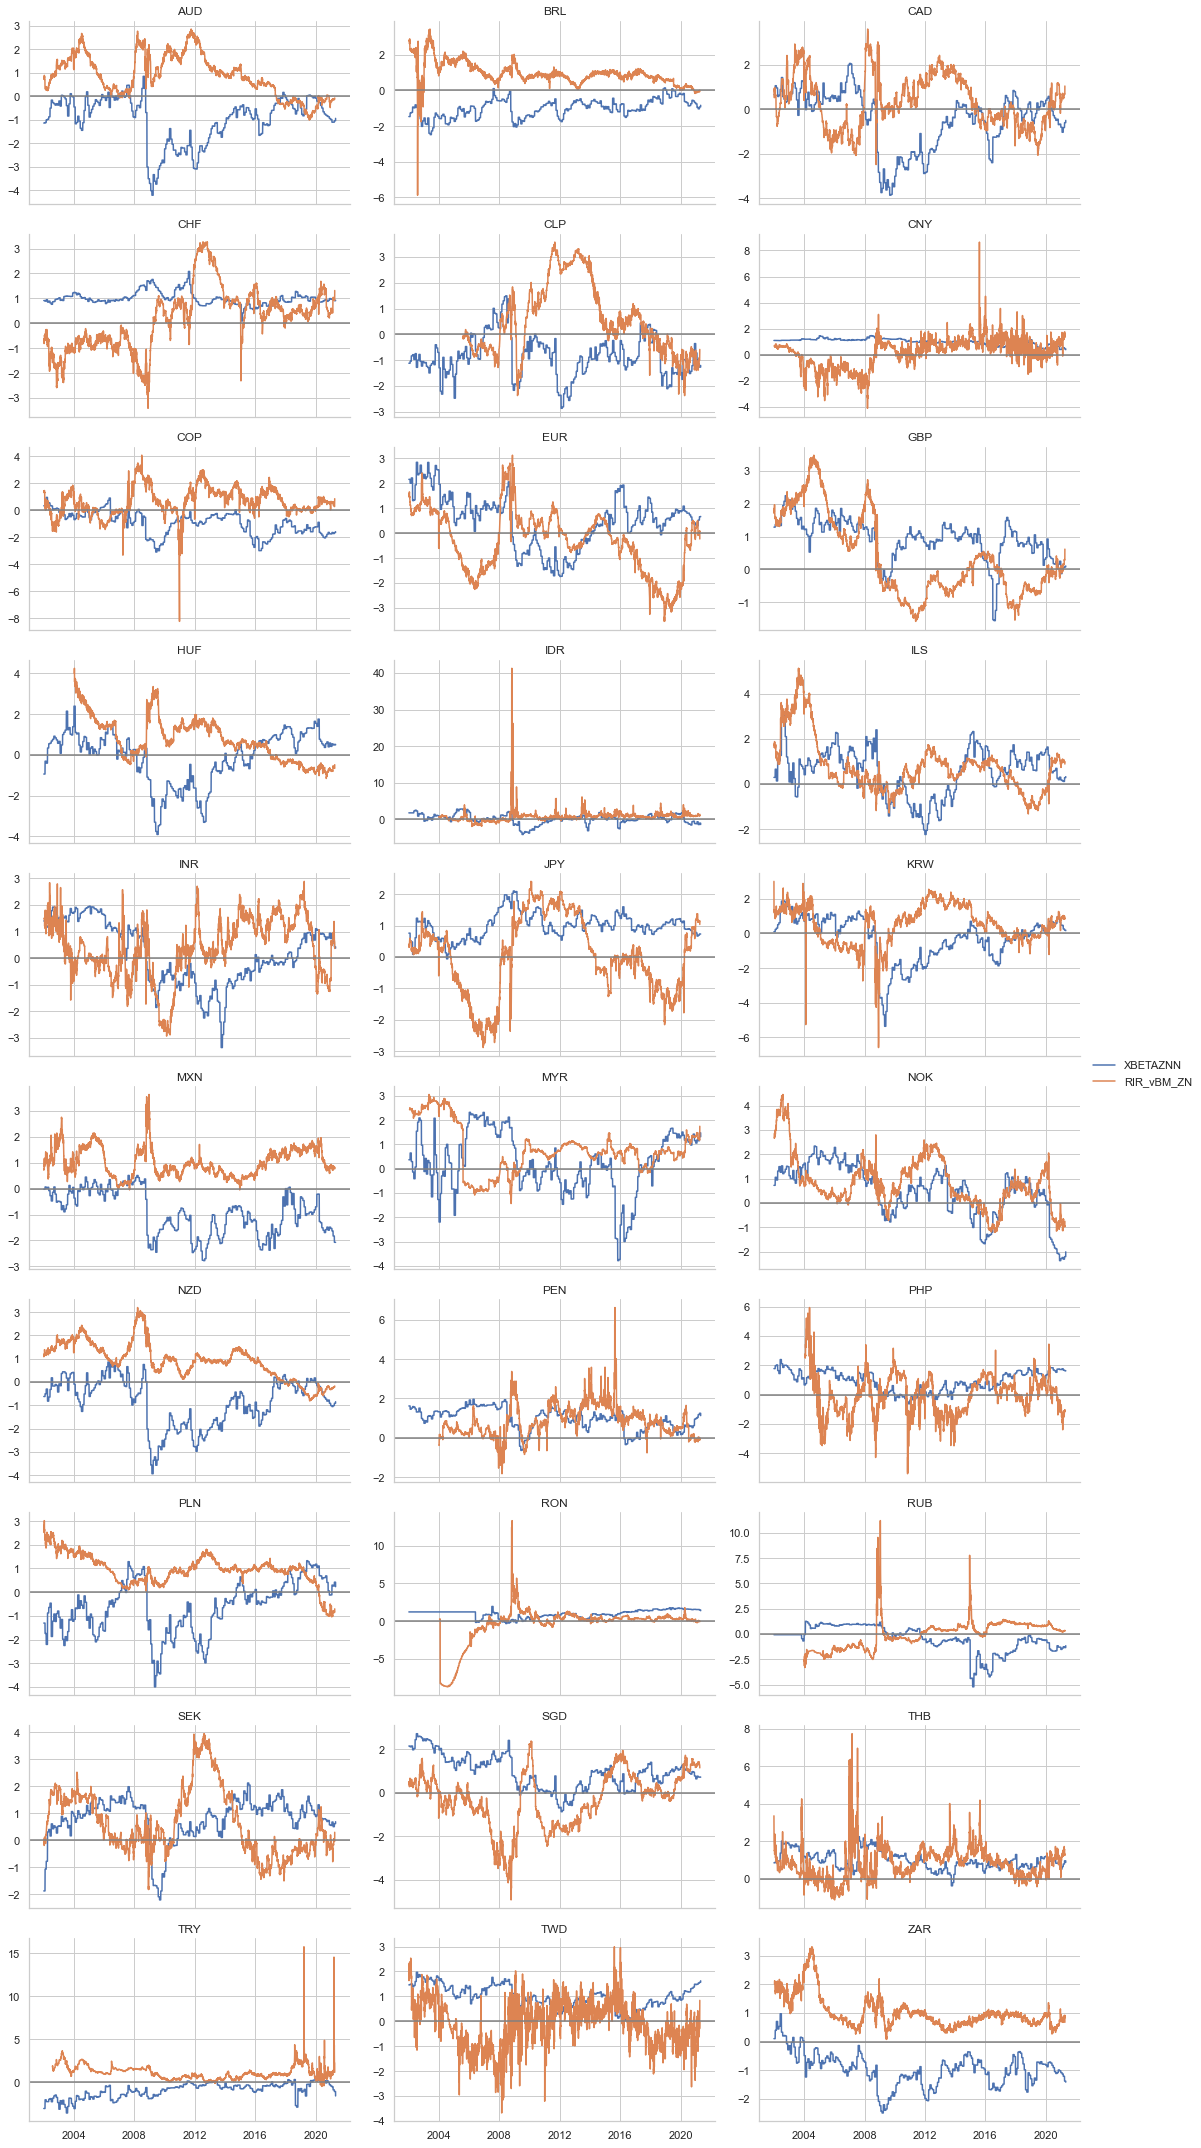

In [311]:
timeline_grid(dfd_zn, xcats=['XBETAZNN','RIR_vBM_ZN'], start_year=2002, cids=cids_fx, 
              hue='cat', same_y=False)

## Scores

### Global feature scores

In [292]:
fx_macro=['GROWTH_vBMZN', 'INF_PRESSURE_ZN', 'XBAL_STRENGTH_ZN', 'PCREDIT_vBM_ZN']
fx_value=['FXWEAK_ZN', 'RIR_vBM_ZN', 'XBETAZNN']
fx_space = fx_macro + fx_value

Missing cross sections:  set()


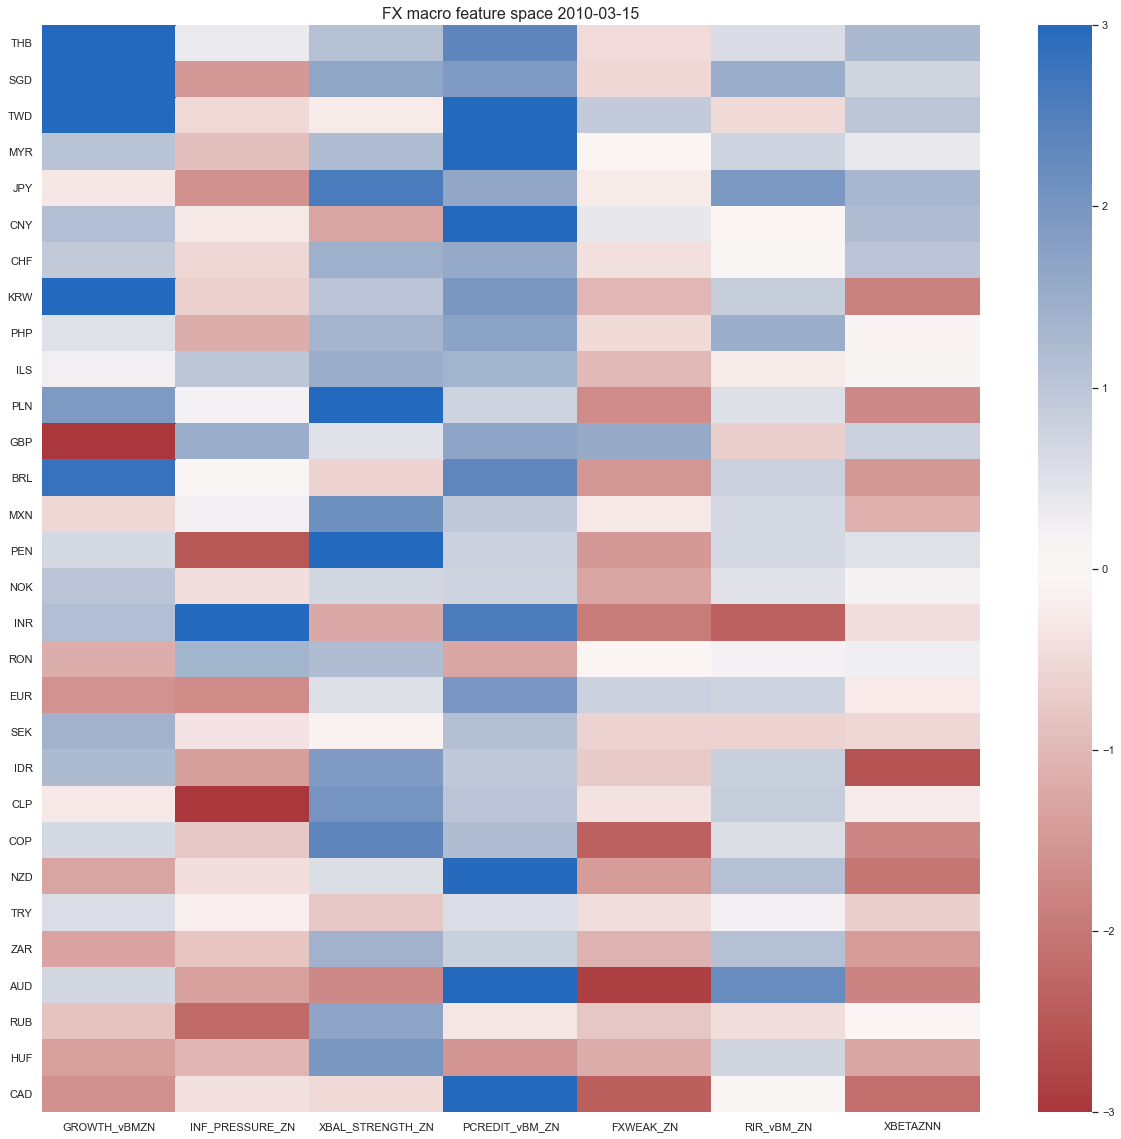

In [316]:
global_score(dfd_zn, xcats=fx_space, cids=cids_fx, score_date='2010-03-15', rank=True, 
             header='FX macro feature space', thresh = 3)

### Historic feature scores 

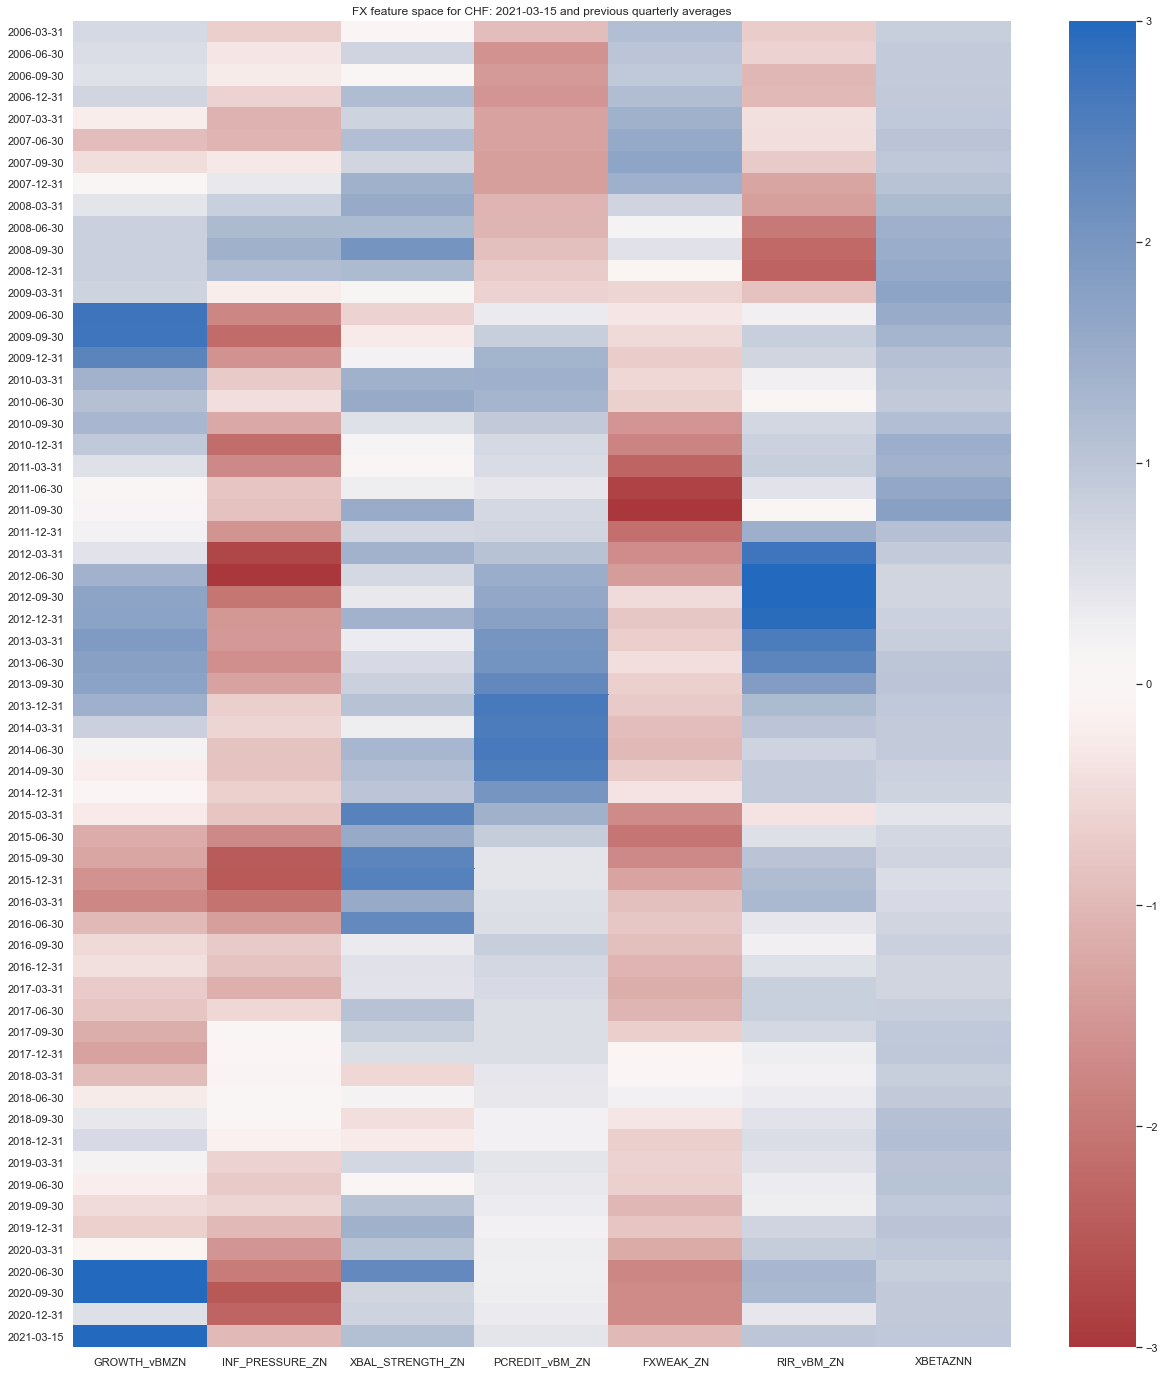

In [300]:
historic_score(dfd_zn, xcats=fx_space, cid='CHF', score_date='2021-03-15', start_date='2006-01-01', 
               freq='Q', agg = 'avg', 
               header='FX feature space', thresh=3)

## Export

In [312]:
dfd_zn.to_feather(f'{path_to_feather}dfd_fxmacro_zn.ftr')